  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

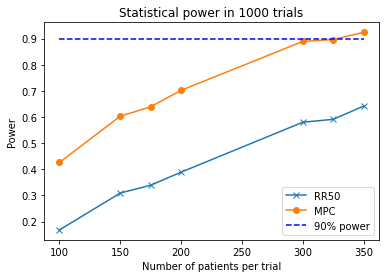

[[0.168 0.426]
 [0.309 0.603]
 [0.339 0.639]
 [0.389 0.702]
 [0.58  0.889]
 [0.591 0.896]
 [0.642 0.924]]


In [1]:
# make a simple picture of trial size vs power

%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 1000
Nlist = [100,150,175,200,300,325,350]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)

In [ ]:
def do_full_case1_sim_v2(figname,numCPUs=9,REPS=5000,DRG=0.2): 
    T1 = time.time()
    highestN = 1000
    sensSET = [1]
    FARset = [0,1]
  
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,5))
    
    #metriclist= ['RR50','MPC']
    metriclist = ['MPC']
    for im,metric_type in enumerate(metriclist):
        #if im==0:
        #Nlist = [75,100,125,150,175,200]
        Nlist = [40,50,60,70,80,90,100]
        
        #else:
        #    Nlist=  [100,200,300,400,500,600,700,800]
            
        for ic,clinTF in enumerate([True,False]):
        
        #ic = 0
            L = len(FARset)*len(sensSET)
            k = pd.DataFrame(np.zeros((L,3)),columns=['FAR','sensitivity','N'])
            ind = 0
            for fi,FAR in enumerate(FARset):
                for si,sensitivity in enumerate(sensSET): 
                    finalN = highestN
                    for N in Nlist:
                        p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                        if p>0.9:
                            finalN=N
                            break
                    print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                    k.iloc[ind,:] = [FAR,sensitivity,finalN]
                    #thexy[ind,:] = [FAR,sensitivity,finalN]
                    ind+=1
            k['N'] = k['N'].astype('int')
            #k = pd.DataFrame({'FAR':thexy[0,:],'sensitivity':thexy[1,:],'N':thexy[2,:].astype('int')})
            thispow = k.pivot('FAR','sensitivity','N')
            print(k)
            sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[im,ic])
            ax[im,ic].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.savefig(figname,dpi=300)
    plt.show()    
    T2 = time.time()
    print(f'Elapsed: {T2-T1}')

In [ ]:
def run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs,im,DRG):
    T1= time.time()
    #lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
    #REPS = 100

    #sensSET = np.linspace(0,1,30)
    #FARset = np.linspace(.1,3,30)
    fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
    metriclist= ['RR50','MPC']
    im = 0
    metric = metriclist[im]
    lowest_N = lowest_N_list[im]
    #for im,metric in enumerate(]):
#        
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=numCPUs,minSz=4,N=lowest_N,DRG=DRG,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[ib]).set(
            title=f'Power Metric={metric} clinTF={clinTF}')
    plt.show()
    T2= time.time()
    print(f'total time = {T2-T1}')
    
REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,50]  # the lowest N for getting 90% power with these parameters

sensSET = [.01, .5, .99]
FARset = [.6, .8, .9]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.3)


#######



REPS=1000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.6,.7,.8,1]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.3)


###

REPS=500
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

###

REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import run1Power_kind,run1trial_kind,build_a_kind_of_diary
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
T1= time.time()
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
REPS = 1000

sensSET = np.linspace(0,1,30)
FARset = np.linspace(.1,3,30)
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
for im,metric in enumerate(['RR50','MPC']):
    lowest_N = lowest_N_list[im]
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=9,minSz=4,N=lowest_N,DRG=0.3,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[im,ib]).set(
                title=f'Power Metric={metric} clinTF={clinTF}')
plt.show()
T2= time.time()
print(f'total time = {T2-T1}')

In [2]:
import pandas as pd
import seaborn as sns
x = FARset
y = sensSET

xyz = np.zeros((len(FARset)*len(sensSET),3))
ind = 0
for i in range(len(FARset)):
    for j in range(len(sensSET)):
        xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
        ind+=1
k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
thispow = k.pivot('FAR','sensitivity','power')
sns.heatmap(thispow, annot=True,linewidths=0.5)

NameError: name 'FARset' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester

def find_detector_thresh_tester():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            print(f'metric={metric_type}, clinTF={clinTF}, lowestN={lowest_N}')
            
def get_pow(N,numCPUs,REPS,DRG):
    # INPUTS:
    # N - total number of patients
    # metric_type - 'MPC' or 'RR50'
    # numCPUs 
    #
    # OUTPUTS:
    #  pow = the % of trials that successfully distinguish drug from placebo
    #
    minSz = 4
    #DRG = 0.3
    PCB = 0.0
    baseline = 56
    test = 84

    #REPS = 10000
    
    if numCPUs == 1:
        plist = [get_one_pow(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS)]
    else:
        with Parallel(n_jobs=numCPUs, verbose=False) as par:
            plist = par(delayed(get_one_pow)(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS))
    plist = np.array(plist,dtype=float)
    pow = np.mean(plist<0.05,axis=0)
    return pow


import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 5000
Nlist = [200,300,325,350,400,600,650,700,750,800]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)
# conclusion: 350 for MPC,700 for RR50

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow_kind_full
import numpy as np
from tqdm.notebook import trange, tqdm
import seaborn as sns
import time
import matplotlib.pyplot as plt
import pandas as pd
numCPUs=9
REPS=5000
DRG=0.2
sensitivity=1
FAR=0
#clinTF=True
#metric_type='MPC'
sensSET = [.33,.66,1]
FARset = [0,.2,.4]
#sensSET = [.5]
#FARset = [.4]

#Nlist= np.linspace(100,900,17).astype('int')


fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
metriclist= ['RR50','MPC']
for im,metric_type in enumerate(metriclist):
    if im==1:
        Nlist = [75,100,125,150,175,200]
    else:
        Nlist=  [100,200,300,400,500,600,700,800]
        
    for ic,clinTF in enumerate([True,False]):
    #ic = 0
        thexy = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for fi,FAR in enumerate(FARset):
            for si,sensitivity in enumerate(sensSET): 
                for N in Nlist:
                    p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                    if p>0.9:
                        finalN=N
                        break
                print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                thexy[ind,:] = [FAR,sensitivity,finalN]
                ind+=1
                
        k = pd.DataFrame(thexy,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[ic]).set(
            title=f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.show()    

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import do_full_case1_sim
from realSim import downsample
number_of_years = 10
num_patients = 10000
sampRATE = 1
howmanydays = sampRATE*30*12*number_of_years
sensitivity = 0.8
FAR = 0.2
clinTF = True
conservativeClinician = 0.8
for N in range(num_patients):
    true_e_diary, true_clin_diary, observed_clin_diary, detector_e_diary, detector_clin_diary=build_full_set_of_diaries(sampRATE,howmanydays,clin_sensitivity,clin_FAR,e_sensitivity,e_FAR)
    
    diary = build_a_kind_of_diary(sampRATE,howmanydays,sensitivity,FAR,clinTF)
    chunks = downsample(diary,90)
    L = len(chunks)
    noChange = 0
    druglist = np.zeros(L)
    
    for i in range(L):
        
        if i==0:
            noChange=1
        else:
            thisChunk = chunks[i]
            lastChunk = chunks[i-1]
            if (thisChunk==0) or (thisChunk <= lastChunk*0.5):
                noChange+=1
            else:
                # there are >= 50% seizures this time vs last. Need a change maybe
                noChange=0
                if np.random.random()<conservativeClinician:
                    # the conservative clinician would be inclined to add med
                    druglist[i] += 1
                    
            if noChange==24:
                # REMOVE DRUG, because no change in 2 years
                druglist[i] = np.max([0,i-1])
            
            

In [ ]:
# try the same with much less subtypes
%reload_ext autoreload
%autoreload 2
from weargroup import get_pow_kind_full,run1trial_kind,makeTrial_kind,getPC
import time
theN = 70
DRG = 0.2
reps = 100
for theN in [20,30,40]:
    d1 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True)
        PC1 = getPC(trialData,baseline=56,test=84)
        P1 = np.median(PC1[:int(theN/2)])
        P1d = np.median(PC1[int(theN/2):])
        d1[K] = P1d-P1
    d2 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False)
        PC2 = getPC(trialData,baseline=56,test=84)
        P2 = np.median(PC2[:int(theN/2)])
        P2d = np.median(PC2[int(theN/2):])
        d2[K] = P2d-P2
    print(f'N = {theN} P1 = {np.mean(d1)} P2 = {np.mean(d2)}')

if 0:
    pF = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    pT = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    print(f'pF = {pF:0.2} pT = {pT:0.2}')
if 0:
    T1 = time.time()
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.4,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    T2 = time.time()
    print(f'Clinical   p={p:0.2} time = {T2-T1}')
    if 0:
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=0.5,FAR=0,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'Sens = 0.5  p={p:0.2} time = {T2-T1}')
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=2,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'FAR = 2   p={p:0.2} time = {T2-T1}')
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    T2 = time.time()
    print(f'clin=FALSE   p={p:0.2} time = {T2-T1}')


In [ ]:


def find_detector_thresh():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000
    fig, ax = plt.subplots(2, 2,figsize=(12,8))

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            
            # sequence through detector sensitivities to reach 90%
            sensitivity_sweep = np.linspace(50,100,26)
            FAR_sweep = np.linspace(0,1,26)
            powgrid = np.zeros((sensitivity_sweep.shape[0],FAR_sweep.shape[0]))
            for a,device_sens in enumerate(sensitivity_sweep):
                for b,FAR in enumerate(FAR_sweep):
                    powgrid[a,b] = run1Power_kind(REPS,numCPUs,minSz,lowest_N,DRG,PCB,baseline,test,device_sens,FAR,clinTF,metric_type)
            ax[plotx,ploty].imshow(powgrid, extent=[0, 1, 0, 1])
            ax[plotx,ploty].title(f'Using metric {metric_type} and clinTF={clinTF}')
    fig.supxlabel('Sensitivity')
    fig.supylabel('FAR')

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

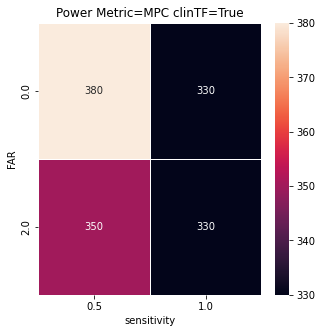

Time = 4416.036698102951


In [25]:
%reload_ext autoreload
%autoreload 2
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
do_simple_case1_sim(clinTF=True)


FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/12 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/12 [00:00<?, ?it/s]

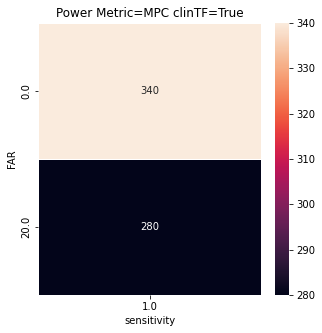

Time = 4124.941466808319


In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUE',clinTF=True,sensLIST = [1],FARlist = [0,20])


FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

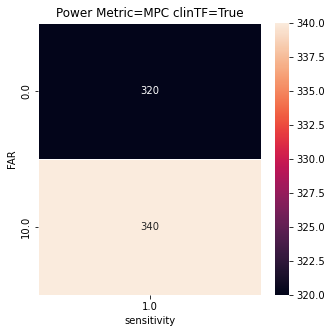

Time = 11193.81279373169


In [10]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUE',clinTF=True,REPS=10000,sensLIST = [1],FARlist = [0,10])


FAR:   0%|          | 0/1 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

N:   0%|          | 0/13 [00:00<?, ?it/s]

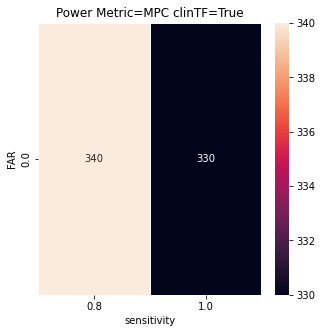

Time = 12918.39755320549


In [13]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
#do_simple_case1_sim(figname='MPCclinFALSE',clinTF=False)
do_simple_case1_sim(figname='MPCclinTRUEsens2',clinTF=True,REPS=10000,sensLIST = [1,.8],FARlist = [0])


In [15]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
clinTF = True
whatmetric = 'RR50'
#for clinTF in [True,False]:
#for whatmetric in ['RR50','MPC']:
do_simple_case1_sim(figname=f'{whatmetric}_clinTF{clinTF}_big10k',numCPUs=9,REPS=10000,clinTF=clinTF,FARlist=[0,10],sensLIST=[0.5,1],metric_type=whatmetric)


[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danielgoldenholz/minifor

AttributeError: module 'linecache' has no attribute '_ipython_cache'

In [8]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import build_many_cases
maxTrials = 10000
maxN = 2000
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.2)
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',O)

  0%|          | 0/20000000 [00:00<?, ?it/s]

Saving E...
Saving O...


In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np

from weargroup import build_many_cases,apply_drug_bulk,make_one_pt_months

from realSim import get_mSF, simulator_base,downsample
from trialSimulator import runSet, applyDrug,makeTrial_defaults,getPC
from trialSimulator import calculate_fisher_exact_p_value, calculate_MPC_p_value
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd
from numpy.random import default_rng
import scipy.stats as stats

In [40]:



np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

maxTrials = 10000
maxN = 2000
REPS = maxTrials*maxN
baseline = 2
test = 3 
trialDur = baseline+test
DRG =0.2
numCPUs=9

def make_one_clin():
    sampRATE = 1
    howmanydays = 28*trialDur
    #ediary,trueclin = make_multi_diaries(sampRATE,howmanydays,makeOBS=False)
    trueclin = simulator_base(sampRATE=sampRATE,number_of_days=howmanydays)
    #ediaryM = downsample(ediary,28)
    trueclinM = downsample(trueclin,28)
    return trueclinM

with Parallel(n_jobs=numCPUs, verbose=False) as par:
    EandC = par(delayed(make_one_pt_months)(trialDur) for _ in trange(REPS))
#    EandC = par(delayed(make_one_clin)() for _ in trange(REPS))
arr = np.array(EandC,dtype=int)
EandC = np.reshape(arr,newshape=(maxTrials,maxN,trialDur*2))
E = EandC[:,:,0:trialDur]
E = apply_drug_bulk(E,maxN,efficacy=DRG,baseline=baseline)
C = EandC[:,:,trialDur:]
C = apply_drug_bulk(C,maxN,efficacy=DRG,baseline=baseline)
    
#E = np.reshape(arr,newshape=(maxTrials,maxN,trialDur))
#Ed = apply_drug_bulk(E,maxN,efficacy=DRG,baseline=baseline)

print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',C)

  0%|          | 0/20000000 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not tuple

In [51]:
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',C)

Saving E...
Saving O...


In [53]:
O = C.copy()


  0%|          | 0/56 [00:00<?, ?it/s]

1575


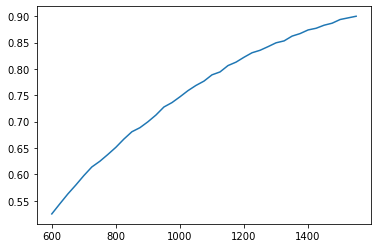

In [19]:
from weargroup import get_pows_given_n


#Ed = apply_drug_bulk(E,maxN,efficacy=0.2,baseline=baseline)

maxTrials = 10000
maxN = 2000
REPS = maxTrials*maxN
baseline = 2
test = 3 
trialDur = baseline+test
DRG =0.2
numCPUs=9

sens = 1
FAR = 0
highestN = 4000
rng = default_rng()
xdata = O.copy()
#account for sensitivity
xdata = np.round(xdata*sens)
#account for FAR
#if FAR>0:
added_sz = np.round(np.random.randn(maxTrials,maxN,trialDur)+28*FAR).astype('int')
added_sz[added_sz<0] =0
xdata += added_sz

B = np.sum(xdata[:,:,:baseline],axis=2) / baseline
T = np.sum(xdata[:,:,baseline:],axis=2) / test
np.seterr(divide='ignore',invalid='ignore')
PC = 100*np.divide((B-T),B)
#print(f'Number of PC nan = {np.sum(np.isnan(PC[:]))}')
RR50 = (PC>=50)+0.0


finalN = highestN
Nlist = np.arange(600,maxN,25)
plist = np.zeros(len(Nlist))
for ni,N in enumerate(tqdm(Nlist)):
    p = get_pows_given_n(maxN,N,maxTrials,PC,mpcTF=True,rng=rng,numCPUs=numCPUs)
    plist[ni] = p
    if p>0.9:
        finalN=N
        break
plt.plot(Nlist[:ni],plist[:ni])
print(finalN)                    

In [2]:
import numpy as np
maxTrials = 10000
maxN = 4000
print(' E...')
E = np.load(f'ePatients{maxTrials}-by-{maxN}.npy')
print(' O...')
O = np.load(f'oPatients{maxTrials}-by-{maxN}.npy')
print('ready.')

 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

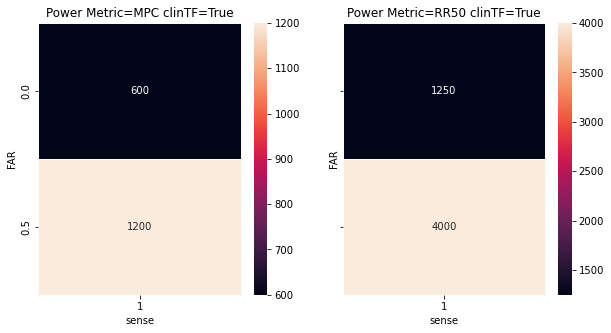

In [72]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(E,[1],[0,.5])
#tryAllClin(O,[.5,.8,1],[0])


  0%|          | 0/40000000 [00:00<?, ?it/s]

Saving E...
Saving O...


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

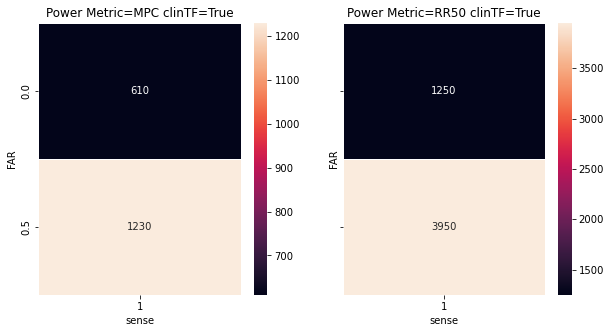

In [73]:
%reload_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import build_many_cases
maxTrials = 10000
maxN = 4000
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.2)
print('Saving E...')
np.save(f'ePatients{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'oPatients{maxTrials}-by-{maxN}.npy',O)




sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

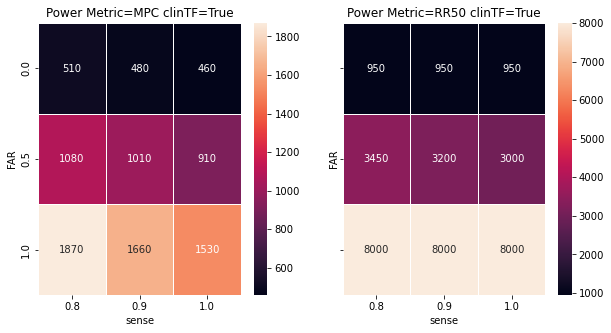

In [74]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(E,[0.8,.9,1],[0,.5,1],maxPOW=.8)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

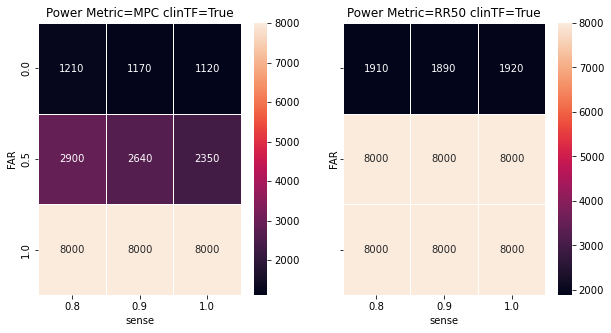

In [75]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
tryAllClin(O,[0.8,.9,1],[0,.5,1],maxPOW=.8)

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

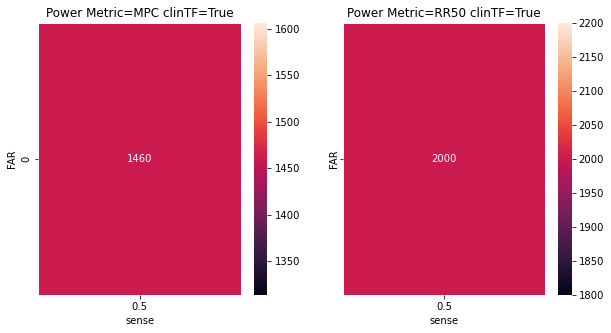

In [76]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[0.5],[0],maxPOW=.8)

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

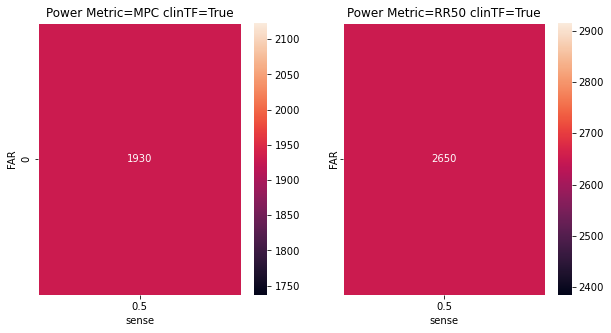

In [77]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[0.5],[0],maxPOW=.9)

sens:   0%|          | 0/5 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/1 [00:00<?, ?it/s]

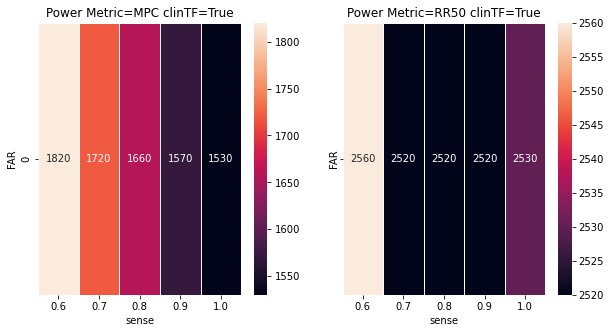

In [78]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[.6,.7,.8,.9,1],[0],maxPOW=.9)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

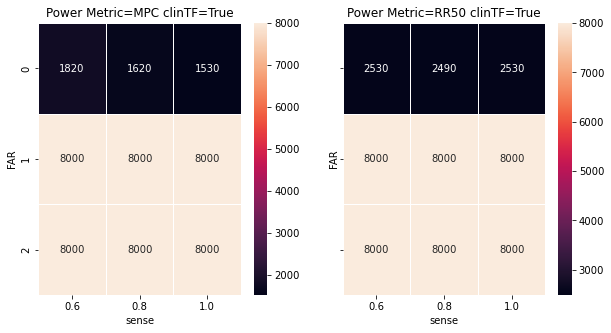

In [79]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin
# This represents clinical trials
tryAllClin(O,[.6,.8,1],[0,1,2],maxPOW=.9)

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

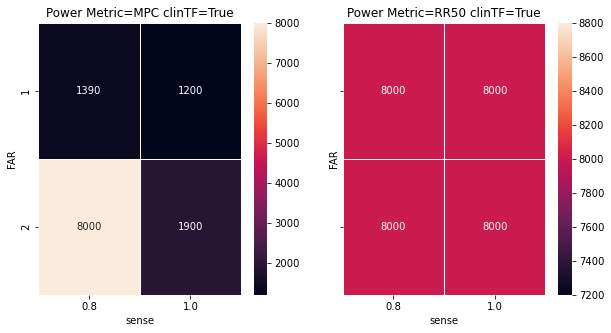

In [86]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.8,1]
FARlist = [1,2]
maxTrials = 10000
maxN = 4000
premake_clin(E,sensLIST,FARlist,f'E-{maxTrials}-by-{maxN}',numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,f'E-{maxTrials}-by-{maxN}',maxPOW=.9)

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

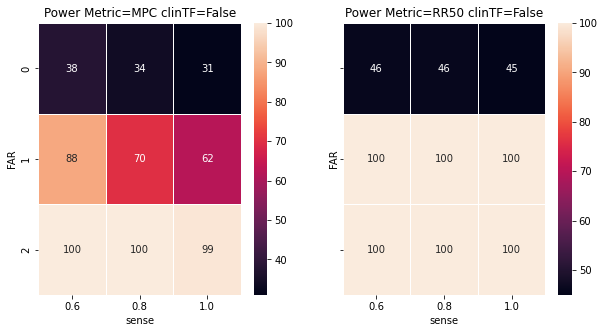

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

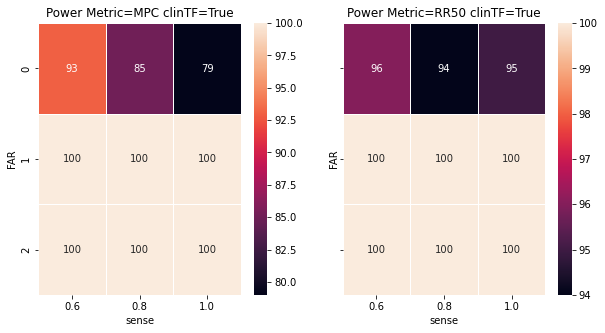

In [90]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000
#premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=False,maxPOW=.9)
#premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=True,maxPOW=.9)


the above was 0.9. Will try maxPOW 0.8

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

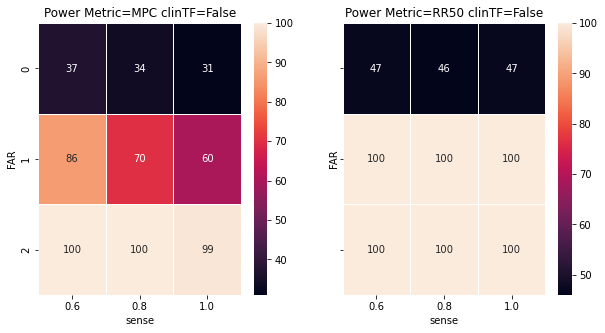

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

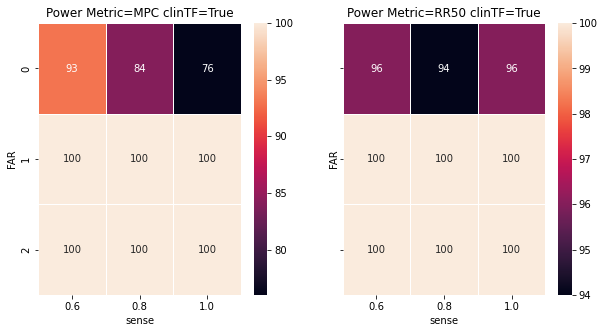

In [91]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000
#premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=False,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=False,maxPOW=.8)
#premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=True,numCPUs=9)
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=True,maxPOW=.8)


The above was built using FAR*sampRATE/4 s.d.
if we lower the s.d, it will look nicer. maybe. Set s.d=1

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW={maxPOW}


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

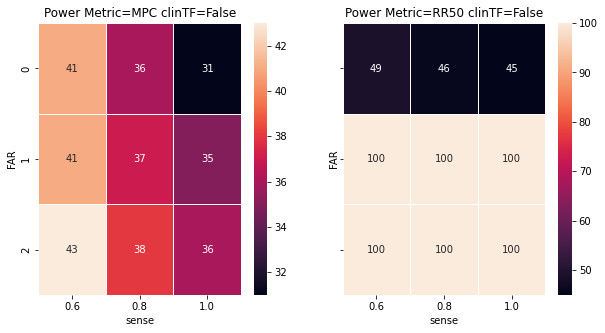

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

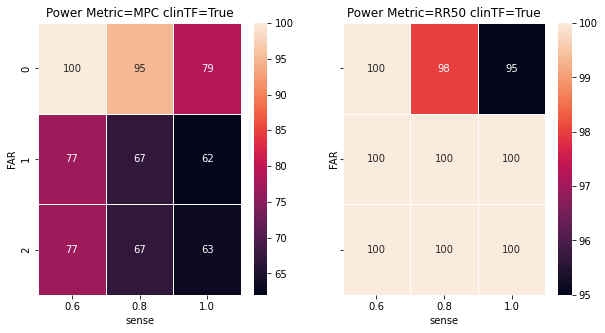

now maxPOW={maxPOW}


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

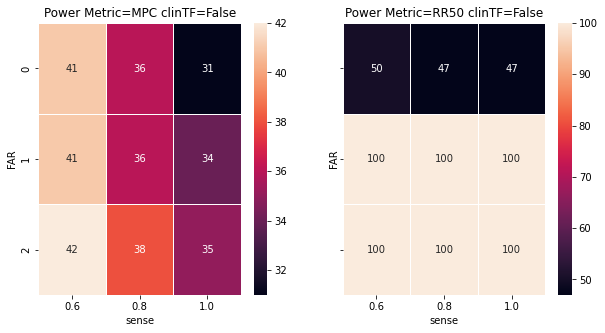

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

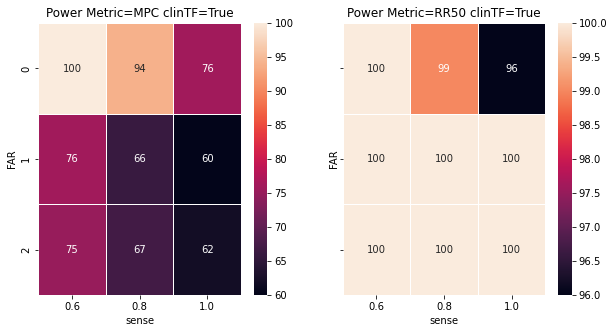

In [95]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)

maxPOW = 0.8
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,maxPOW=maxPOW)



In [3]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [0,1,2]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinF.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinT.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

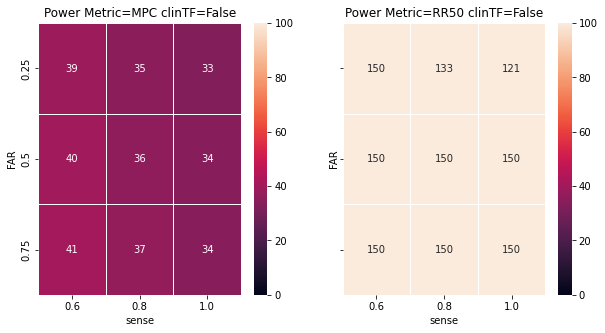

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

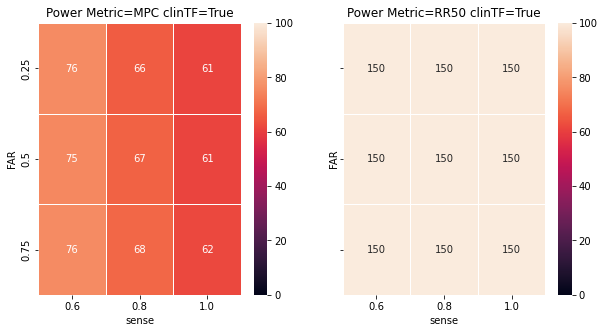

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [.25,.5,.75]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFsmallFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTsmallFAR.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

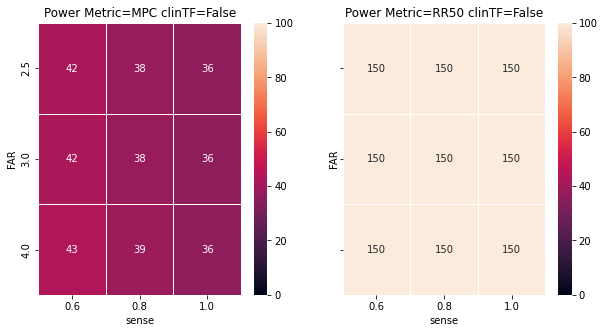

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

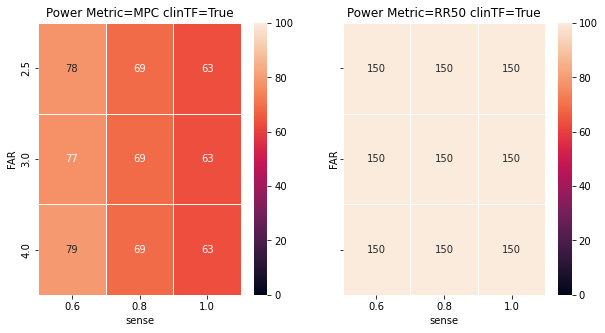

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [2.5,3,4]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFbigFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTbigFAR.csv',maxPOW=maxPOW)


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

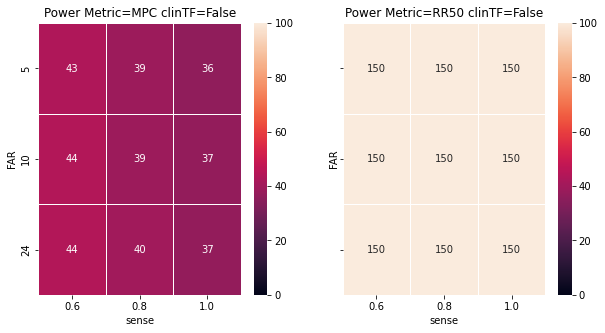

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

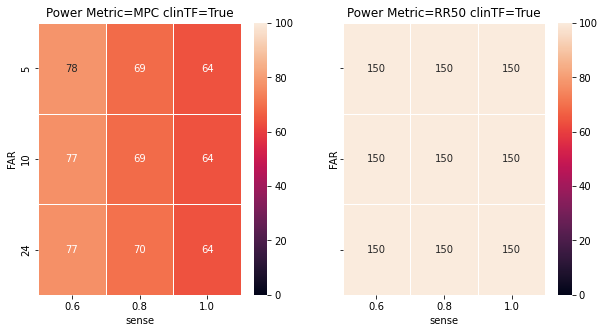

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import tryAllClin,premake_clin
# This represents clinical trials
sensLIST = [0.6,0.8,1]
FARlist = [5,10,24]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinFbiggerFAR.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinTbiggerFAR.csv',maxPOW=maxPOW)


 E...
 O...
ready.


sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

now maxPOW=0.9


sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

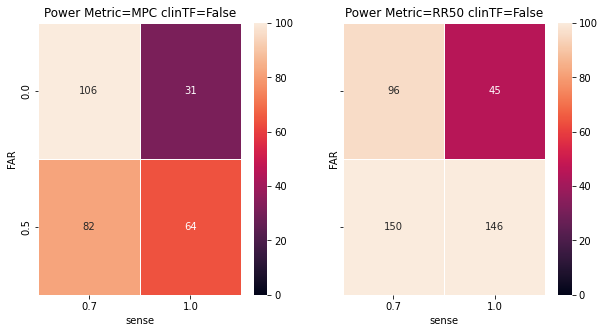

sens:   0%|          | 0/2 [00:00<?, ?it/s]

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import tryAllClin,premake_clin
# This represents clinical trials

maxTrials = 10000
maxN = 4000
print(' E...')
E = np.load(f'ePatients{maxTrials}-by-{maxN}.npy')
print(' O...')
O = np.load(f'oPatients{maxTrials}-by-{maxN}.npy')
print('ready.')

sensLIST = [0.7,1]
FARlist = [0,.5]
maxTrials = 10000
maxN = 4000

clinTF = False
premake_clin(E,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)
clinTF = True
premake_clin(O,sensLIST,FARlist,maxTrials,maxN,clinTF=clinTF,numCPUs=9)

maxPOW = 0.9
print(f'now maxPOW={maxPOW}')
clinTF = False
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinF.csv',maxPOW=maxPOW)
clinTF = True
tryAllClin(maxN,maxTrials,sensLIST,FARlist,clinTF=clinTF,fn_csv='3x3_clinT.csv',maxPOW=maxPOW)

the above used 0.25 for cutdown. below I try 0.1

 E...
 O...
ready.


sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

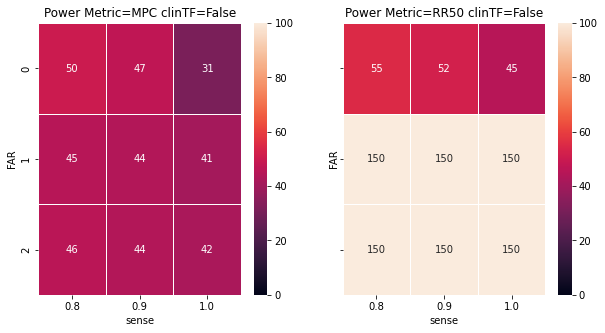

sens:   0%|          | 0/3 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

do_a_clin_set(sensLIST=[0.8,.9,1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True)

the above was cutdown 0.1. This looks bad.


 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

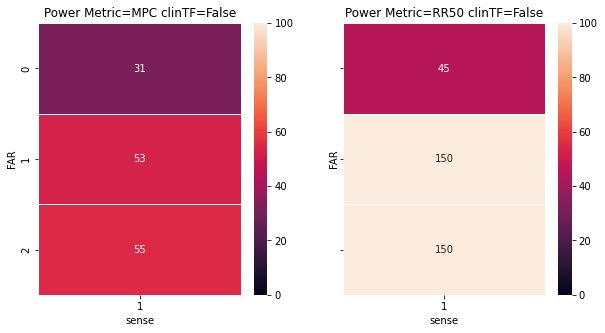

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

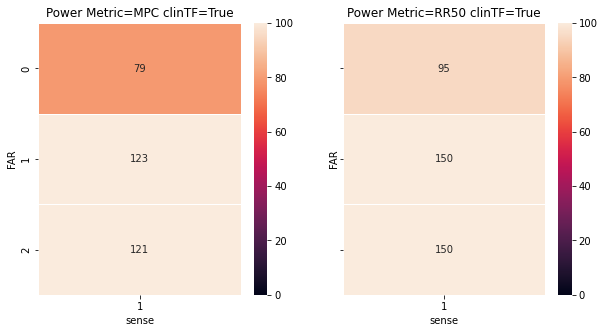

In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

do_a_clin_set(sensLIST=[1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True)

nope. This is not working for us.



  0%|          | 0/40000000 [00:00<?, ?it/s]

Saving E...
Saving O...
Done.
 E...
 O...
ready.


sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

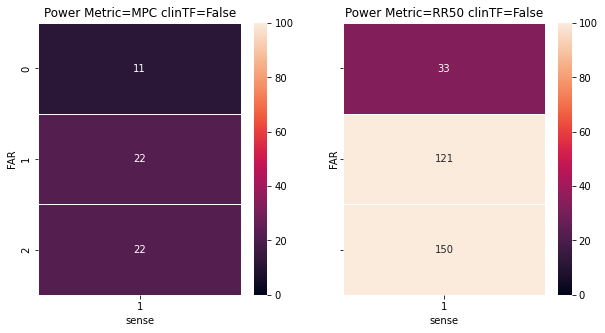

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

adding FAR/sense:   0%|          | 0/10000 [00:00<?, ?it/s]

sens:   0%|          | 0/1 [00:00<?, ?it/s]

FAR:   0%|          | 0/3 [00:00<?, ?it/s]

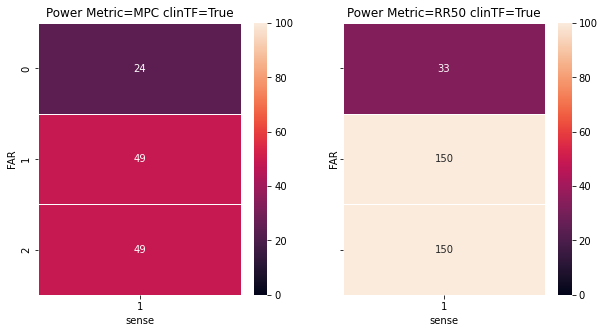

In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup import do_a_clin_set

from weargroup import build_many_cases
maxTrials = 10000
maxN = 4000
DRG = 0.3
filePREFIX = f'Patients30'
E,O = build_many_cases(numCPUs=9,trials=maxTrials,maxN=maxN,baseline=2,test=3,DRG=0.3)
print('Saving E...')
np.save(f'e{filePREFIX}{maxTrials}-by-{maxN}.npy',E)
print('Saving O...')
np.save(f'o{filePREFIX}{maxTrials}-by-{maxN}.npy',O)
print('Done.')

do_a_clin_set(sensLIST=[1],FARlist=[2,1,0],
              csvFN='grid3',doPremake=True,filePREFIX=filePREFIX)

In [12]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import tryManyTrials

obsPows,allPows = tryManyTrials(numCPUs=9,N=100,REPS=9,
    sensLIST=[0.8,1],farLIST=[0])


obs:   0%|          | 0/9 [00:00<?, ?it/s]

doinbg the grid


reps:   0%|          | 0/9 [00:00<?, ?it/s]

reps:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
pow = findThresh(numCPUs=9,REPS=10000,maxN=1000,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=1,FAR=0,metricMPC_TF=True)
print(pow)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating PCs = 1114.2660341262817


findthresh:   0%|          | 0/9 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 7.28769326210022
900


In [47]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_4k.npy',numCPUs=9,REPS=10000,maxN=4000,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0,metricMPC_TF=True)
print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 97.0 minutes
Saving....


findthresh:   0%|          | 0/390 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 4.0 minutes


findthresh:   0%|          | 0/390 [00:00<?, ?it/s]

Thresh N = thisN
Calculating wins = 6.0 minutes
Threshold RR50 = 2760 Threshold MPC = 2590


this seems WAY too high. will repeat, but use a lower max.
On the other hand, since self-report is so imperfect, maybe this is an important point that huge numbers are typically needed.
Conversely, maybe this means that self-report must be higher, since most studies are much smaller and still figure out good drugs.

In [48]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_2.9k.npy',numCPUs=9,REPS=10000,maxN=2900,DRG=0.2,PCB=0,minSz=4,
           baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0,metricMPC_TF=True)
print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 72.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Thresh N = {thisN}
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Thresh N = {thisN}
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


In [50]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
for K in range(6):
    tRR,tMP = findThresh(fn='PC_sens0.5_FAR0_10k_2.9k.npy',numCPUs=9,REPS=10000,maxN=2900,DRG=0.2,PCB=0,minSz=4,
            baseline=2,test=3,clinTF=True,sensitivity=0.5,FAR=0)
    print(f'Threshold RR50 = {tRR} Threshold MPC = {tMP}')

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 71.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 71.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 69.0 minutes
Saving....


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 2130
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/280 [00:00<?, ?it/s]

Thresh N = 1970
Calculating wins = 1.0 minutes
Threshold RR50 = 2130 Threshold MPC = 1970


The above sets the limt of thresholds. Whatever max is found for RR50
observed, that is the highest we ever have to check after that.
When we only care about MPC, we can use THAT threshold.
These same thresholds should be used for e-seizures.
Tested 7 times, we always got 2130 RR50 and 1970 MPC.

In [51]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import build_a_trial,get_a_patient,findThresh
for sensitivity in [0.7,.8,.9,1]:
    for FAR in [0,.5,1,2]:
        fn = f'PC_sens{sensitivity}_FAR{FAR}_10k_3k.npy'
        tRR,tMP = findThresh(fn=fn,numCPUs=9,REPS=10000,maxN=3000,DRG=0.2,PCB=0,minSz=4,
                baseline=2,test=3,clinTF=True,sensitivity=sensitivity,FAR=FAR)
        print(f'S={sensitivity} F={FAR} Threshold RR50 = {tRR} Threshold MPC = {tMP}')
        

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 61.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2180
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2030
Calculating wins = 1.0 minutes
S=0.7 F=0 Threshold RR50 = 2180 Threshold MPC = 2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 33.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2720
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1640
Calculating wins = 1.0 minutes
S=0.7 F=0.5 Threshold RR50 = 2720 Threshold MPC = 1640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 38.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1620
Calculating wins = 1.0 minutes
S=0.7 F=1 Threshold RR50 = 2990 Threshold MPC = 1620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1600
Calculating wins = 1.0 minutes
S=0.7 F=2 Threshold RR50 = 2990 Threshold MPC = 1600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 57.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2020
Calculating wins = 1.0 minutes
S=0.8 F=0 Threshold RR50 = 2170 Threshold MPC = 2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2680
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1650
Calculating wins = 1.0 minutes
S=0.8 F=0.5 Threshold RR50 = 2680 Threshold MPC = 1650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 38.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1620
Calculating wins = 1.0 minutes
S=0.8 F=1 Threshold RR50 = 2990 Threshold MPC = 1620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=0.8 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 54.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2010
Calculating wins = 1.0 minutes
S=0.9 F=0 Threshold RR50 = 2170 Threshold MPC = 2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2620
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1660
Calculating wins = 1.0 minutes
S=0.9 F=0.5 Threshold RR50 = 2620 Threshold MPC = 1660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 39.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2980
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1630
Calculating wins = 1.0 minutes
S=0.9 F=1 Threshold RR50 = 2980 Threshold MPC = 1630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 48.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=0.9 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 44.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2170
Calculating wins = 1.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2010
Calculating wins = 1.0 minutes
S=1 F=0 Threshold RR50 = 2170 Threshold MPC = 2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 29.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2560
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1660
Calculating wins = 1.0 minutes
S=1 F=0.5 Threshold RR50 = 2560 Threshold MPC = 1660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 34.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 2920
Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1630
Calculating wins = 1.0 minutes
S=1 F=1 Threshold RR50 = 2920 Threshold MPC = 1630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 44.0 minutes
Saving....


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes


findthresh:   0%|          | 0/290 [00:00<?, ?it/s]

Thresh N = 1610
Calculating wins = 1.0 minutes
S=1 F=2 Threshold RR50 = 2990 Threshold MPC = 1610


	RR50						MPC			
	FAR						FAR			
sens	0	0.5	1	2		sens	0	0.5	1	2
0.5	2130					0.5	1970			
0.7	2180	2720	2990	2990		0.7	2030	1640	1620	1600
0.8	2170	2680	2990	2990		0.8	2020	1650	1620	1610
0.9	2170	2620	2980	2990		0.9	2010	1660	1630	1610
1	2170	2560	2920	2990		1	2010	1660	1630	1610

this grid shows that using ONLY variabiliy in FAR between patients and then
adding a constant FAR to patients that way is no good.

In [65]:

%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')
buildSET_of_N([1],[.5,1,2],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


Loading...done.
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2030. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 62.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    0  2180  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 59.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2010. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    0  2180  2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

as can be seen above, the code did not help much.
the above code used this

        Xadder = np.zeros(len(Xs))
        for samp in range(len(X)):
            Xadder[samp] += downsampleRATE*(1-0.5*FAR) + FAR*np.sum(np.random.rand(downsampleRATE))
        Xadder = np.max([[np.zeros(len(X))],[Xadder]],axis=0)   
        Xs += Xadder
        

In [66]:

%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')
buildSET_of_N([1],[.5,1,2],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


Loading...done.
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2030. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030
   sensitivity  FAR  RR50   MPC
0          0.5    0  2180  2030


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 61.0 minutes
Saving....
Threshold ...2180. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    0  2180  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 58.0 minutes
Saving....
Threshold ...2170. runtime = 1.0 minutes
Threshold ...2020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    0  2170  2020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 54.0 minutes
Saving....
Threshold ...2170. runtime = 1.0 minutes
Threshold ...2010. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    0  2170  2010


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.5,.7,.8,.9,1],[0],recalc=False,numCPUs=9,thiscsv='the_obs.csv')
#buildSET_of_N([0.7,.8,.9,1],[0],recalc=True,numCPUs=9,thiscsv='the_sens.csv')


SyntaxError: EOL while scanning string literal (weargroup_v2.py, line 157)

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.05,.5,1],[0],recalc=True,numCPUs=9,thiscsv='deleteme.csv',clinTF=False,REPS=1000,maxN=600,DRG=0.3)


PC_sens0.05_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 5.0 minutes
Saving....
Threshold ...510. runtime = 0.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0         0.05    0   510  470
PC_sens0.5_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...500. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   500  460
PC_sens1_FAR0_1000x600.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...490. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   490  440
   sensitivity  FAR  RR50  MPC
0         0.05    0   510  470
0         0.50    0   500  460
0         1.00    0   490  440


In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.05,.5,1],[0],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3)

PC_sens0.05_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 48.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0         0.05    0  1320  1270
PC_sens0.5_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260
PC_sens1_FAR0_1000x2000.npy


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 3.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    0  1320  1260
   sensitivity  FAR  RR50   MPC
0         0.05    0  1320  1270
0         0.50    0  1320  1260
0         1.00    0  1320  1260


In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.1,1],[0,1],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1040. runtime = 0.0 minutes
Threshold ...980. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    0  1040  980


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1490. runtime = 0.0 minutes
Threshold ...1490. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.1    1  1490  1490


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes
Saving....
Threshold ...1040. runtime = 0.0 minutes
Threshold ...980. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0  1040  980


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1490. runtime = 0.0 minutes
Threshold ...1190. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1490  1190
   sensitivity  FAR  RR50   MPC
0          0.1    0  1040   980
0          0.1    1  1490  1490
0          1.0    0  1040   980
0          1.0    1  1490  1190


In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N

buildSET_of_N([0.1,1],[0,1],recalc=True,numCPUs=9,thiscsv='deletemeT.csv',clinTF=True,REPS=1000,maxN=800,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 7.0 minutes
Saving....
Threshold ...640. runtime = 0.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    0   640  580


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...790. runtime = 0.0 minutes
Threshold ...790. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.1    1   790  790


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...620. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   620  570


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...790. runtime = 0.0 minutes
Threshold ...750. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   790  750
   sensitivity  FAR  RR50  MPC
0          0.1    0   640  580
0          0.1    1   790  790
0          1.0    0   620  570
0          1.0    1   790  750


In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N


buildSET_of_N([.5],[0],recalc=True,numCPUs=9,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3)

#buildSET_of_N([0.1,.5,.75,1],[0,.5,1,2],recalc=True,numCPUs=9,thiscsv='bigRun.csv',clinTF=True,REPS=10000,maxN=800,DRG=0.3)

trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1310. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1310  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1310  1260


In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=2000,maxN=2000,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=5000,maxN=2000,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating wins = 9.0 minutes
Saving....
Threshold ...1340. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1340  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1340  1260


trials:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1330. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1330  1270
   sensitivity  FAR  RR50   MPC
0          0.5    0  1330  1270


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 4.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1260. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1260


In [8]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1050. runtime = 0.0 minutes
Threshold ...990. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0  1050  990
   sensitivity  FAR  RR50  MPC
0          0.5    0  1050  990


In [9]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1060. runtime = 0.0 minutes
Threshold ...1000. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1060  1000
   sensitivity  FAR  RR50   MPC
0          0.5    0  1060  1000


In [10]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...1320. runtime = 0.0 minutes
Threshold ...1270. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1270
   sensitivity  FAR  RR50   MPC
0          0.5    0  1320  1270


In [12]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)
buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1200,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...350. runtime = 0.0 minutes
Threshold ...230. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  230
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  230


In [13]:

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=2000,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...350. runtime = 0.0 minutes
Threshold ...220. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  220
   sensitivity  FAR  RR50  MPC
0          0.5    0   350  220


trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...320. runtime = 0.0 minutes
Threshold ...200. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   320  200
   sensitivity  FAR  RR50  MPC
0          0.5    0   320  200


In [15]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=1500,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=200,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=1000,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=2000,maxN=450,DRG=0.3,mini=mini)

buildSET_of_N([.5],[0],recalc=True,thiscsv='bigRunObs.csv',clinTF=True,REPS=5000,maxN=450,DRG=0.3,mini=mini)

trials:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating wins = 0.0 minutes
Saving....
Threshold ...380. runtime = 0.0 minutes
Threshold ...240. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   380  240
   sensitivity  FAR  RR50  MPC
0          0.5    0   380  240


trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating wins = 1.0 minutes
Saving....
Threshold ...360. runtime = 0.0 minutes
Threshold ...220. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  220
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  220


trials:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating wins = 2.0 minutes
Saving....
Threshold ...360. runtime = 0.0 minutes
Threshold ...230. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  230
   sensitivity  FAR  RR50  MPC
0          0.5    0   360  230


trials:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWear.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini)

buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunEWear.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1360


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1290. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.5  1390  1290


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1180. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.5  1390  1180


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1130. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.5  1390  1130


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1390  1390
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   890   530
0          0.7  0.5  1390  1360
0          0.7  1.0  1390  1390
0          0.7  2.0  1390  1390
0          0.8  0.0   880   530
0          0.8  0.5  1390  1290
0          0.8  1.0  1390  1390
0          0.8  2.0  1390  1390
0          0.9  0.0   880   510
0          0.9  0.5  1390  1180
0          0.9  1.0  1390  1390
0          0.9  2.0  1390  1390
0          1.0  0.0   860   520
0          1.0  0.5  1390  1130
0          1.0  1.0  1390  1390
0          1.0  2.0  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   820  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...790. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1390  790


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...960. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1  1390  960


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1330. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1330


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   810  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...740. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1390  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...900. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1  1390  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1240. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1240


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   820  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...720. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1390  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...860. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1390  860


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1140. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1390  1140


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...810. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1390  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...810. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1390  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1080. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1390  1080
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   820   460
0          0.7  0.5  1390   790
0          0.7  1.0  1390   960
0          0.7  2.0  1390  1330
0          0.8  0.0   810   450
0          0.8  0.5  1390   740
0          0.8  1.0  1390   900
0          0.8  2.0  1390  1240
0          0.9  0.0   820   450
0          0.9  0.5  1390   720
0          0.9  1.0  1390   860
0          0.9  2.0  1390  1140
0          1.0  0.0   810   430
0          1.0  0.5  1390   680
0          1.0  1.0  1390   810
0          1.0  2.0  1390  1080


In [17]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=False,thiscsv='bigRunClinWear.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini)

buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=False,thiscsv='bigRunEWear.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini)


Loading...done.
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1360
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1390
Loading...done.
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390
Loading...done.
Threshold ...880. runtime = 0.0 minutes
Threshold ...

KeyboardInterrupt: 

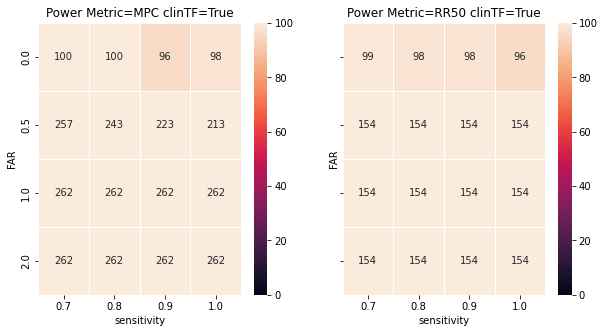

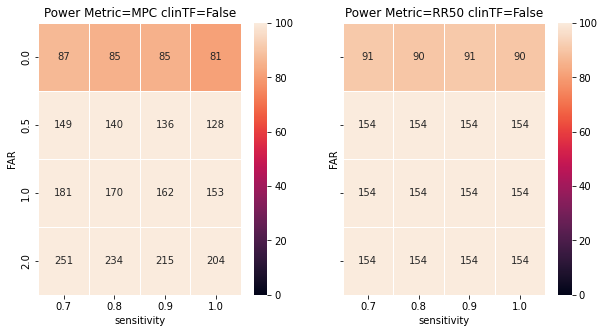

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# this is the plot when inflater was 2

fnList = ['bigRunClinWear.csv','bigRunEWear.csv']
clinList = [True,False]
for ci,clinTF in enumerate(clinList):
    d2=pd.read_csv(fnList[ci])
    fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
    maxList = [530, 900]
    mlist=['MPC','RR50']
    for mi,metric_type in enumerate(mlist):
        d3 = d2.copy()
        d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
        d3=d3.drop(columns=mlist[1-mi])
        thispow = d3.pivot('FAR','sensitivity',metric_type)
        sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
        ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.show()


In [50]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWearInf1.csv',clinTF=True,REPS=10000,maxN=1400,DRG=0.2,mini=mini,inflater=1)
#buildSET_of_N([.7,.8,.9,1],[0,.5,1,2],recalc=True,thiscsv='bigRunEWearInf1.csv',clinTF=False,REPS=10000,maxN=1400,DRG=0.2,mini=mini,inflater=1)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1130. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1390  1130


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1360. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1390  1360


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1050. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.5  1390  1050


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1260. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1390  1260


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1390. runtime = 1.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1390  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...820. runtime = 0.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   820  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 9.0 minutes
Saving....
Threshold ...840. runtime = 0.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   840  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   900  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 8.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2   900  500
   sensitivity  FAR  RR50  MPC
0            1  0.0   820  430
0            1  0.5   840  440
0            1  1.0   900  460
0            1  2.0   900  500


TypeError: 'str' object cannot be interpreted as an integer

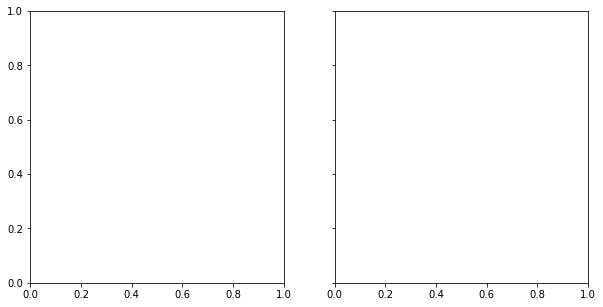

In [52]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinWearInf1.csv',clinTF=False,REPS=10000,maxN=910,DRG=0.2,mini=mini,inflater=1)


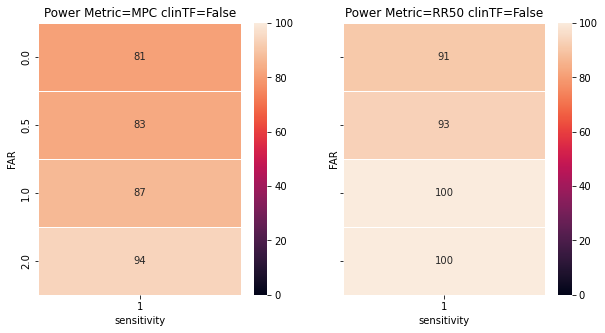

In [54]:
d2=pd.read_csv('bigRunClinWearInf1.csv')
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
maxList = [530, 900]
mlist=['MPC','RR50']
for mi,metric_type in enumerate(mlist):
    d3 = d2.copy()
    d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
    d3=d3.drop(columns=mlist[1-mi])
    thispow = d3.pivot('FAR','sensitivity',metric_type)
    sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
plt.show()

In [56]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N
mini=False
buildSET_of_N([1],[0,.5,1,2],recalc=True,thiscsv='bigRunClinTWearInf1.csv',clinTF=True,REPS=10000,maxN=1210,DRG=0.2,mini=mini,inflater=1)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...860. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...970. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   970  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1200. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1200  660
   sensitivity  FAR  RR50  MPC
0            1  0.0   860  510
0            1  0.5   920  540
0            1  1.0   970  540
0            1  2.0  1200  660


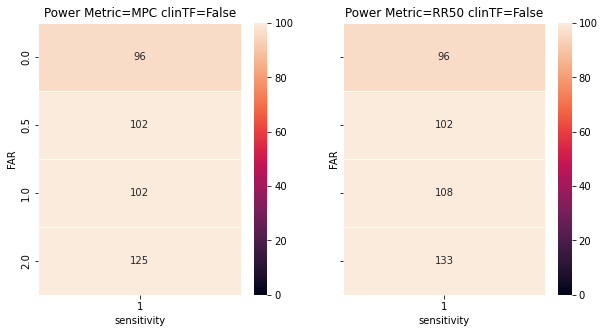

In [57]:
d2=pd.read_csv('bigRunClinTWearInf1.csv')
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))     
maxList = [530, 900]
mlist=['MPC','RR50']
for mi,metric_type in enumerate(mlist):
    d3 = d2.copy()
    d3[metric_type] = np.round(100*d2[metric_type] / maxList[mi]).astype('int')
    d3=d3.drop(columns=mlist[1-mi])
    thispow = d3.pivot('FAR','sensitivity',metric_type)
    sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[mi],vmin=0,vmax=100)
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
plt.show()

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   910  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...990. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   990  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1310. runtime = 1.0 minutes
Threshold ...720. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1310  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...990. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   990  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1310. runtime = 1.0 minutes
Threshold ...700. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2  1310  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   910  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1240. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1240  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   890  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   980  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1210. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1210  670
   sensitivity  FAR  RR50  MPC
0          0.7  0.0   880  540
0          0.7  0.5   910  550
0          0.7  1.0   990  560
0          0.7  2.0  1310  720
0          0.8  0.0   880  520
0          0.8  0.5   920  540
0          0.8  1.0   990  560
0          0.8  2.0  1310  700
0          0.9  0.0   880  530
0          0.9  0.5   910  530
0          0.9  1.0   980  560
0          0.9  2.0  1240  680
0          1.0  0.0   880  520
0          1.0  0.5   890  520
0          1.0  1.0   980  540
0          1.0  2.0  1210  670
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9f/mx3t8lrj4719csmgr9pw7n1r0000gr/T/ipykernel_13342/3450349424.py", line 8, in <cell line: 8>
    drawGrid(fn)
  File "/Users/danielgoldenholz/Documents/GitHub/WEARsimulator/weargroup_v2.py", line 194, in drawGrid
    ax[mi].set_title(f'Power Metric={metric_type} clinTF={clinTF}')
NameError: name 'clinTF' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in st

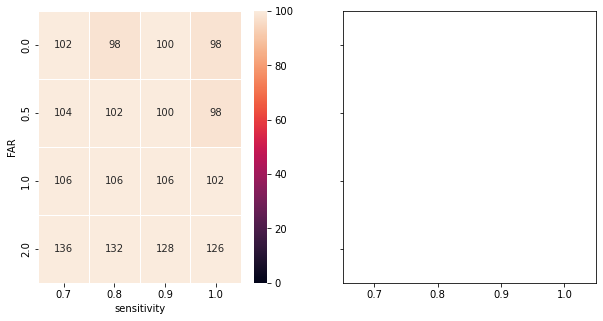

In [60]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'bigRunClinT-sandf-Inf1.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=1)
drawGrid(fn)


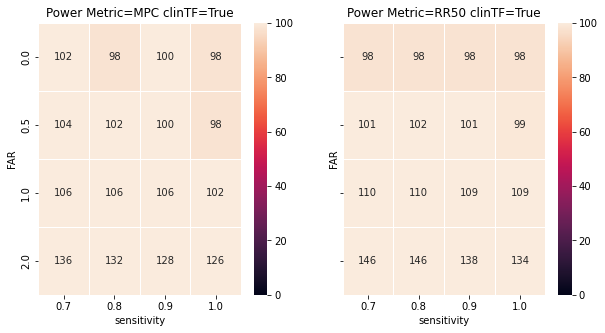

In [61]:
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1   920  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...1010. runtime = 0.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1010  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   870  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...910. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5   910  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...930. runtime = 0.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1   930  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...920. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1   920  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...980. runtime = 0.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2   980  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...900. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5   900  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...890. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1   890  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1000. runtime = 0.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1000  550
   sensitivity  FAR  RR50  MPC
0          0.7  0.0   880  530
0          0.7  0.5   890  530
0          0.7  1.0   920  540
0          0.7  2.0  1010  570
0          0.8  0.0   870  530
0          0.8  0.5   910  530
0          0.8  1.0   930  540
0          0.8  2.0   980  560
0          0.9  0.0   880  520
0          0.9  0.5   890  530
0          0.9  1.0   920  530
0          0.9  2.0   980  560
0          1.0  0.0   870  510
0          1.0  0.5   900  520
0          1.0  1.0   890  520
0          1.0  2.0  1000  550


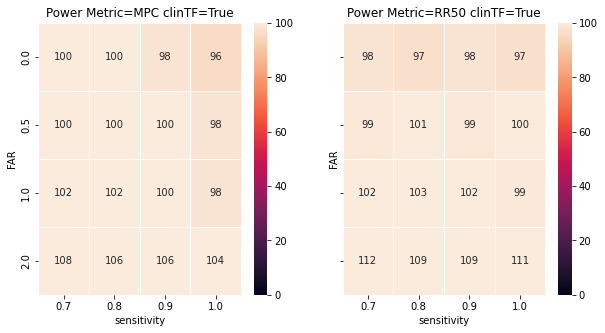

In [62]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'bigRunClinT-sandf-Inf0.5.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=0.5)
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1060. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1490  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1200. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1490  1200


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1490. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1490  1490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...880. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...990. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1490  990


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1490  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1400. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1490  1400


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...950. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1490  950


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1080. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1490  1080


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1320. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1490  1320


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 0.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...920. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1490  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1020. runtime = 0.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1490  1020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1490. runtime = 1.0 minutes
Threshold ...1250. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1490  1250
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   880   530
0          0.7  0.5  1490  1060
0          0.7  1.0  1490  1200
0          0.7  2.0  1490  1490
0          0.8  0.0   880   520
0          0.8  0.5  1490   990
0          0.8  1.0  1490  1120
0          0.8  2.0  1490  1400
0          0.9  0.0   870   520
0          0.9  0.5  1490   950
0          0.9  1.0  1490  1080
0          0.9  2.0  1490  1320
0          1.0  0.0   870   510
0          1.0  0.5  1490   920
0          1.0  1.0  1490  1020
0          1.0  2.0  1490  1250


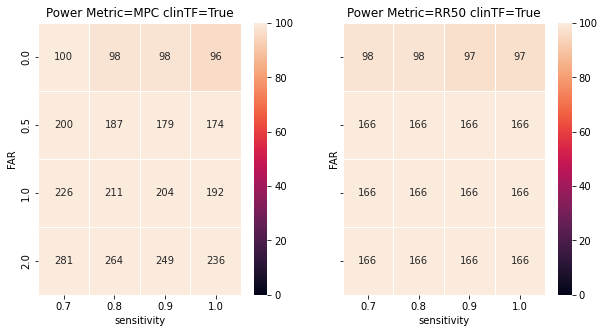

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'tryA_true_inf2_3.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=2/3)
drawGrid(fn,clinTF=True)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   900  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...975. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1495  975


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1210. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1495  1210


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   885  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1005. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1495  1005


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   865  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1055. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1495  1055


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   875  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...865. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  865


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1015. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1015
   sensitivity  FAR  RR50   MPC
0          0.7  0.0   900   535
0          0.7  0.5  1495   975
0          0.7  1.0  1495  1065
0          0.7  2.0  1495  1210
0          0.8  0.0   885   530
0          0.8  0.5  1495   930
0          0.8  1.0  1495  1005
0          0.8  2.0  1495  1120
0          0.9  0.0   865   515
0          0.9  0.5  1495   900
0          0.9  1.0  1495   980
0          0.9  2.0  1495  1055
0          1.0  0.0   875   515
0          1.0  0.5  1495   865
0          1.0  1.0  1495   930
0          1.0  2.0  1495  1015


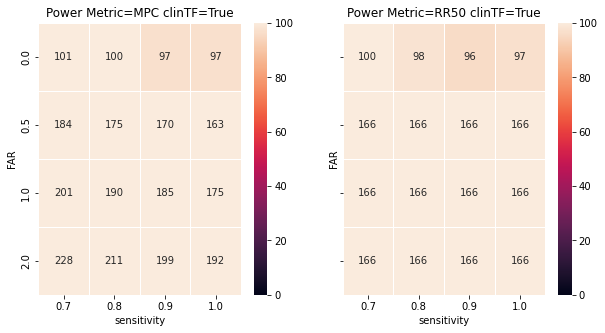

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
fn = 'tryA_true_inf1_3.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=True,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=1/3)
drawGrid(fn,clinTF=True)

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
clinTF = True
fn = f'tryA_{clinTF}_inf1.csv'
inflater = 1
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
drawGrid(fn,clinTF=clinTF)
inflater = 4/3
fn = f'tryA_{clinTF}_inf10.csv'
buildSET_of_N([0.7,0.8,0.9,1],[0,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
drawGrid(fn,clinTF=clinTF)


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 580, in run
    self.join_executor_internals()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 812, in join_executor_internals
    self.shutdown_workers()
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 796, in shutdown_workers
    n_children_to_stop += 1
  File "/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/backend/synchronize.py", line 113, in __exit__
    return self._semlock.release()
ValueError: semaphore or lock released too many ti

KeyboardInterrupt: 

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 32.0 minutes
Saving....
Threshold ...910. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   910  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  520
   sensitivity  FAR  RR50  MPC
0          0.5    0   910  550
0          1.0    0   870  520


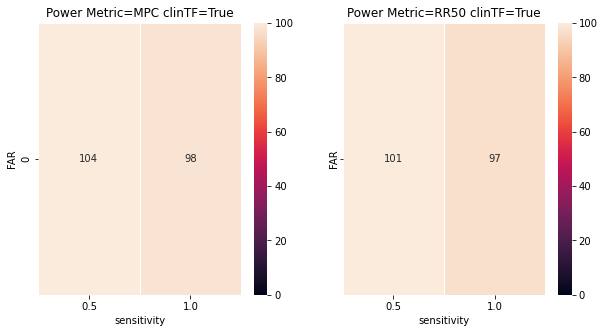

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   795  430
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  490
0          1.0    0   795  430


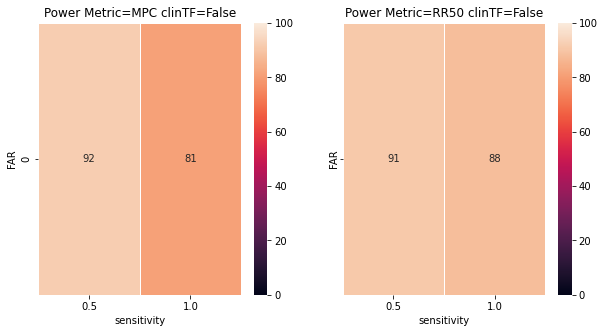

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 2.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1495
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495  1495
0            1  1.0  1495  1495
0            1  2.0  1495  1495


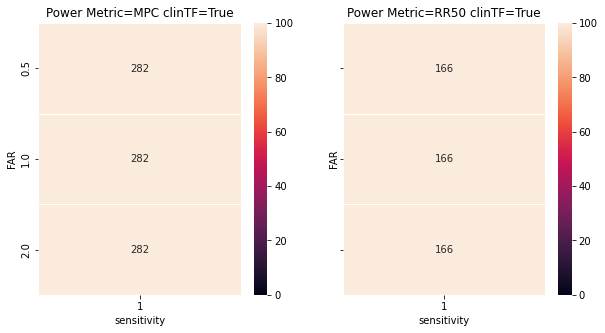

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...965. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  965


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1495
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495   965
0            1  1.0  1495  1495
0            1  2.0  1495  1495


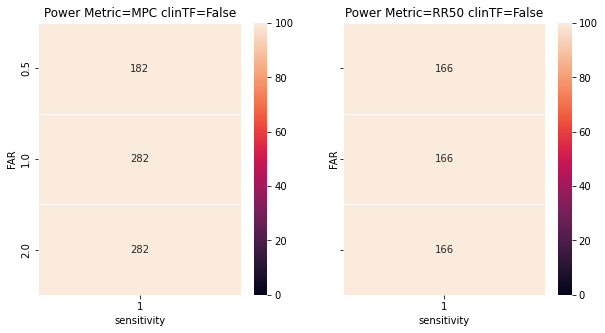

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 20/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf6.66.csv'
    buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf6.66.csv'
    buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)


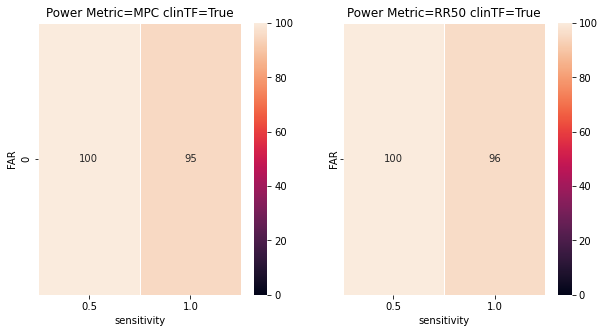

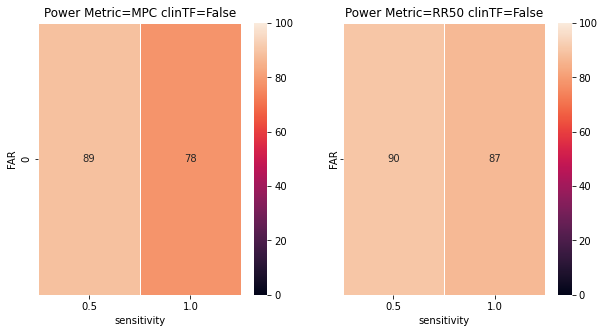

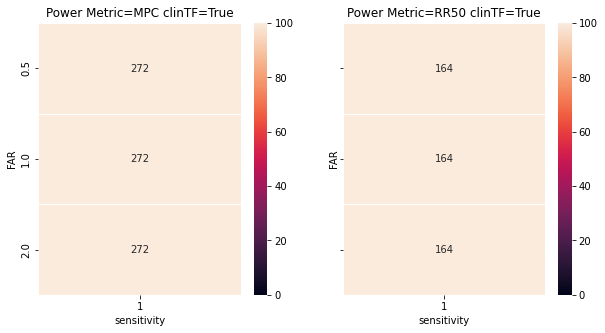

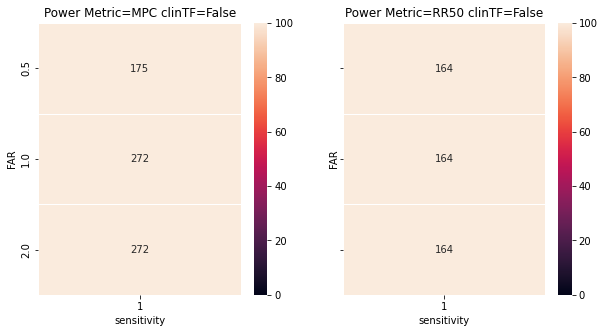

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 20/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf6.66.csv'
    #buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf6.66.csv'
    #buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

The above shows us that inflation 20/3 does not get us far.

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 32.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   880  510
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  540
0          1.0    0   880  510


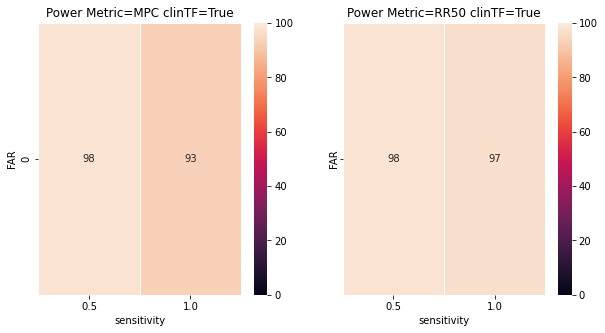

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...825. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...425. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  425
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  490
0          1.0    0   810  425


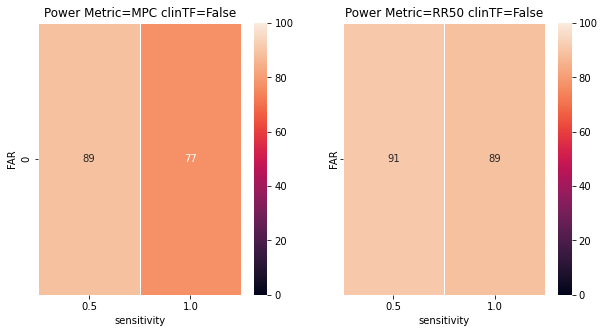

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1015. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1015


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1230. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1230
   sensitivity  FAR  RR50   MPC
0            1  0.5  1495   900
0            1  1.0  1495  1015
0            1  2.0  1495  1230


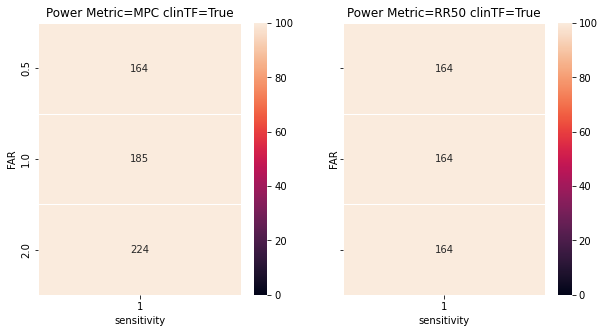

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1495  725
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  595
0            1  1.0  1495  650
0            1  2.0  1495  725


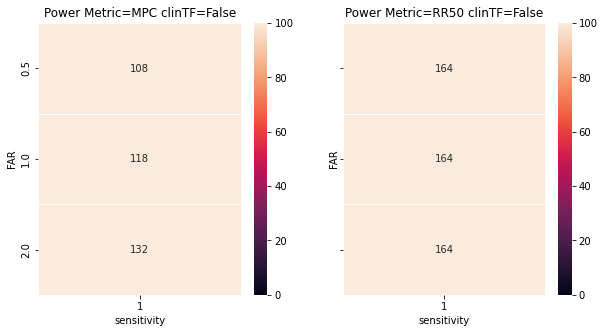

In [4]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 2/3
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_nofar_inf0.66.csv'
    buildSET_of_N([0.5,1],[0],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)
for clinTF in [True,False]:
    fn = f'tryRange_{clinTF}_onlyFar_inf0.66.csv'
    buildSET_of_N([1],[0.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1170. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1170


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1215. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.5  1495  1215


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1405. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    1  1495  1405


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   900  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...695. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.1  1495  695


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6  0.2  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6  0.5  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1280. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6    1  1495  1280


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.6    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   875  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...685. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  685


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1055. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.5  1495  1055


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1195. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    1  1495  1195


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7    2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...665. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...955. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  955


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...975. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  975


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    1  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1390. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8    2  1495  1390


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...645. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  645


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  890


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    1  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1300. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9    2  1495  1300


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   860  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...855. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  855


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...910. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  910


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1020. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    1  1495  1020


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1245. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1    2  1495  1245
   sensitivity  FAR  RR50   MPC
0          0.5  0.0   890   545
0          0.5  0.1  1495   730
0          0.5  0.2  1495  1170
0          0.5  0.5  1495  1215
0          0.5  1.0  1495  1405
0          0.5  2.0  1495  1495
0          0.6  0.0   900   540
0          0.6  0.1  1495   695
0          0.6  0.2  1495  1065
0          0.6  0.5  1495  1120
0          0.6  1.0  1495  1280
0          0.6  2.0  1495  1495
0          0.7  0.0   875   535
0          0.7  0.1  1495   685
0          0.7  0.2  1495   980
0          0.7  0.5  1495  1055
0          0.7  1.0  1495  1195
0          0.7  2.0  1495  1495
0          0.8  0.0   880   530
0          0.8  0.1  1495   665
0          0.8  0.2  1495   955
0          0.8  0.5  1495   975
0          0.8  1.0  1495  1120
0          0.8  2.0  1495  1390
0          

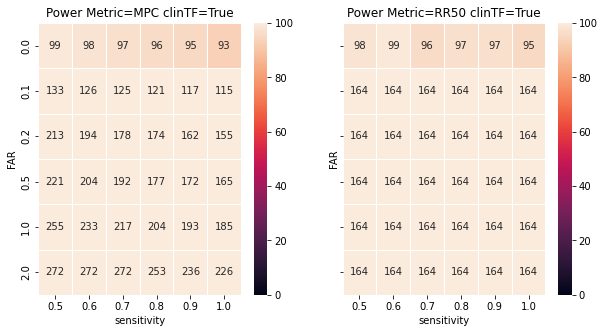

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...705. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  705


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.5  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    1  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...970. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    2  1495  970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    0   805  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.1  1495  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...655. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.2  1495  655


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...700. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6  0.5  1495  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...780. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    1  1495  780


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...900. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.6    2  1495  900


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   805  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...625. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  625


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.5  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    2  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   815  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...625. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.5  1495  625


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...690. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    1  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...800. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    2  1495  800


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   805  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.5  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...655. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    1  1495  655


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    2  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...435. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   805  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.5  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    1  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    2  1495  740
   sensitivity  FAR  RR50  MPC
0          0.5  0.0   830  495
0          0.5  0.1  1495  595
0          0.5  0.2  1495  705
0          0.5  0.5  1495  740
0          0.5  1.0  1495  840
0          0.5  2.0  1495  970
0          0.6  0.0   805  470
0          0.6  0.1  1495  570
0          0.6  0.2  1495  655
0          0.6  0.5  1495  700
0          0.6  1.0  1495  780
0          0.6  2.0  1495  900
0          0.7  0.0   805  455
0          0.7  0.1  1495  535
0          0.7  0.2  1495  625
0          0.7  0.5  1495  670
0          0.7  1.0  1495  730
0          0.7  2.0  1495  830
0          0.8  0.0   815  455
0          0.8  0.1  1495  520
0          0.8  0.2  1495  600
0          0.8  0.5  1495  625
0          0.8  1.0  1495  690
0          0.8  2.0  1495  800
0          0.9  0.0   805  440
0       

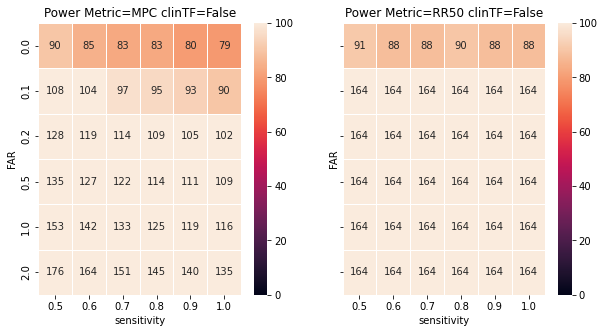

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
inflater = 2/3
for clinTF in [True,False]:
    fn = f'tryBigRange_{clinTF}_nofar_inf0.66.csv'
    buildSET_of_N([0.5,.6,.7,.8,.9,1],[0,.1,.2,.5,1,2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
    drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...1065. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1065  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1135. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1135


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   885  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1055  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...685. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  685


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...925. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  925


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1045  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...920. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1055  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...845. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  845


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  890


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1030  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...805. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  805


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...850. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  850
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   900   545
0          0.5  0.05  1065   570
0          0.5  0.10  1495   740
0          0.5  0.15  1495  1060
0          0.5  0.20  1495  1135
0          0.7  0.00   885   530
0          0.7  0.05  1055   550
0          0.7  0.10  1495   685
0          0.7  0.15  1495   925
0          0.7  0.20  1495   945
0          0.8  0.00   880   530
0          0.8  0.05  1045   545
0          0.8  0.10  1495   660
0          0.8  0.15  1495   870
0          0.8  0.20  1495   920
0          0.9  0.00   870   515
0          0.9  0.05  1055   535
0          0.9  0.10  1495   650
0          0.9  0.15  1495   845
0          0.9  0.20  1495   890
0          1.0  0.00   870   500
0          1.0  0.05  1030   525
0          1.0  0.10  1495   630
0          1.0  0.15  

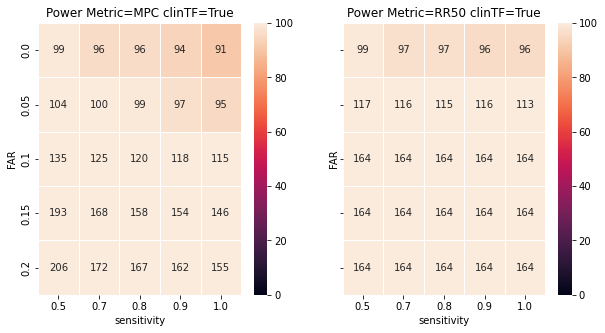

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1030  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...700. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  700


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   805  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1000. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1000  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...620. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  620


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1000. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1000  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...570. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  570


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   820  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1020  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   795  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1015. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1015  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  555
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   830  490
0          0.5  0.05  1030  505
0          0.5  0.10  1495  575
0          0.5  0.15  1495  660
0          0.5  0.20  1495  700
0          0.7  0.00   805  465
0          0.7  0.05  1000  480
0          0.7  0.10  1495  540
0          0.7  0.15  1495  605
0          0.7  0.20  1495  620
0          0.8  0.00   795  455
0          0.8  0.05  1000  470
0          0.8  0.10  1495  525
0          0.8  0.15  1495  570
0          0.8  0.20  1495  590
0          0.9  0.00   820  440
0          0.9  0.05  1020  455
0          0.9  0.10  1495  500
0          0.9  0.15  1495  550
0          0.9  0.20  1495  575
0          1.0  0.00   795  440
0          1.0  0.05  1015  455
0          1.0  0.10  1495  500
0          1.0  0.15  1495  530
0          1.0

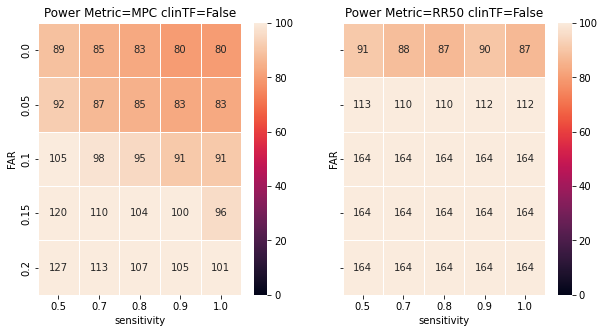

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   900  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 27.0 minutes
Saving....
Threshold ...1085. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1085  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1065. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1065


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1155. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1155


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   895  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1080. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1080  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...680. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1000. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1000


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   890  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1040. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1040  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...665. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1045  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...875. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  875


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1045  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...640. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  640


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...815. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  815


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...855. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  855
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   900   550
0          0.5  0.05  1085   555
0          0.5  0.10  1495   730
0          0.5  0.15  1495  1065
0          0.5  0.20  1495  1155
0          0.7  0.00   895   530
0          0.7  0.05  1080   555
0          0.7  0.10  1495   680
0          0.7  0.15  1495   930
0          0.7  0.20  1495  1000
0          0.8  0.00   890   535
0          0.8  0.05  1040   540
0          0.8  0.10  1495   665
0          0.8  0.15  1495   870
0          0.8  0.20  1495   930
0          0.9  0.00   870   515
0          0.9  0.05  1045   540
0          0.9  0.10  1495   650
0          0.9  0.15  1495   840
0          0.9  0.20  1495   875
0          1.0  0.00   870   515
0          1.0  0.05  1045   535
0          1.0  0.10  1495   640
0          1.0  0.15  

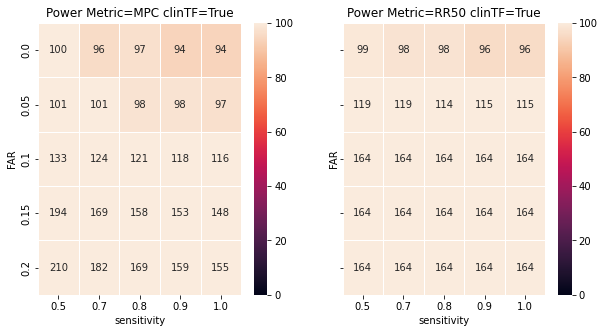

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...830. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   830  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1030  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...705. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  705


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   815  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1025  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   800  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1025  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   800  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1030  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...580. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  580


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   815  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1005. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1005  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  555
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   830  490
0          0.5  0.05  1030  510
0          0.5  0.10  1495  590
0          0.5  0.15  1495  670
0          0.5  0.20  1495  705
0          0.7  0.00   815  465
0          0.7  0.05  1025  470
0          0.7  0.10  1495  545
0          0.7  0.15  1495  605
0          0.7  0.20  1495  630
0          0.8  0.00   800  450
0          0.8  0.05  1025  470
0          0.8  0.10  1495  520
0          0.8  0.15  1495  575
0          0.8  0.20  1495  600
0          0.9  0.00   800  440
0          0.9  0.05  1030  465
0          0.9  0.10  1495  505
0          0.9  0.15  1495  555
0          0.9  0.20  1495  580
0          1.0  0.00   815  430
0          1.0  0.05  1005  450
0          1.0  0.10  1495  500
0          1.0  0.15  1495  530
0          1.0

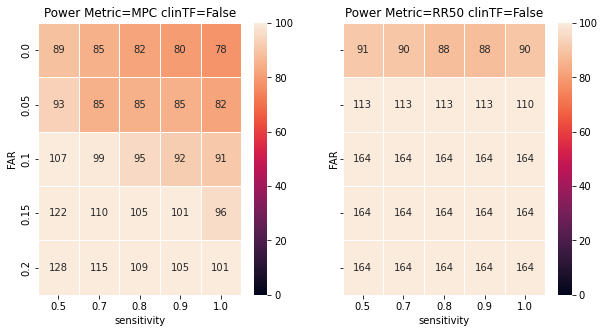

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...1180. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1180  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...730. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  730


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1125. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1125


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1230. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1230


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...1140. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1140  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...670. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  670


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...960. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  960


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1035. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1035


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1130. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1130  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...660. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  660


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...920. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  920


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...980. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  980


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1135. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1135  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...880. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  880


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...930. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  930


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...855. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   855  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...1125. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1125  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...845. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  845


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...890. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  890
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   545
0          0.5  0.05  1180   590
0          0.5  0.10  1495   730
0          0.5  0.15  1495  1125
0          0.5  0.20  1495  1230
0          0.7  0.00   890   530
0          0.7  0.05  1140   565
0          0.7  0.10  1495   670
0          0.7  0.15  1495   960
0          0.7  0.20  1495  1035
0          0.8  0.00   880   530
0          0.8  0.05  1130   555
0          0.8  0.10  1495   660
0          0.8  0.15  1495   920
0          0.8  0.20  1495   980
0          0.9  0.00   880   515
0          0.9  0.05  1135   545
0          0.9  0.10  1495   650
0          0.9  0.15  1495   880
0          0.9  0.20  1495   930
0          1.0  0.00   855   510
0          1.0  0.05  1125   540
0          1.0  0.10  1495   610
0          1.0  0.15  

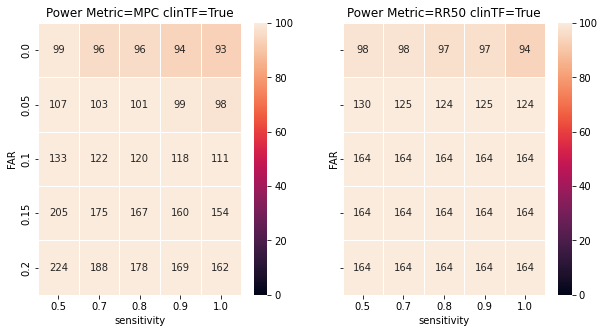

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...825. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   825  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1100. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1100  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...695. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  695


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...720. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  720


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   800  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1095. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1095  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...635. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  635


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   810  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1070. runtime = 1.0 minutes
Threshold ...470. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1070  470


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...585. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  585


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...610. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  610


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   795  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1070. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1070  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   815  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1075. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1075  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  560
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   825  500
0          0.5  0.05  1100  515
0          0.5  0.10  1495  600
0          0.5  0.15  1495  695
0          0.5  0.20  1495  720
0          0.7  0.00   800  460
0          0.7  0.05  1095  495
0          0.7  0.10  1495  540
0          0.7  0.15  1495  610
0          0.7  0.20  1495  635
0          0.8  0.00   810  450
0          0.8  0.05  1070  470
0          0.8  0.10  1495  520
0          0.8  0.15  1495  585
0          0.8  0.20  1495  610
0          0.9  0.00   795  440
0          0.9  0.05  1070  475
0          0.9  0.10  1495  510
0          0.9  0.15  1495  560
0          0.9  0.20  1495  575
0          1.0  0.00   815  430
0          1.0  0.05  1075  450
0          1.0  0.10  1495  495
0          1.0  0.15  1495  545
0          1.0

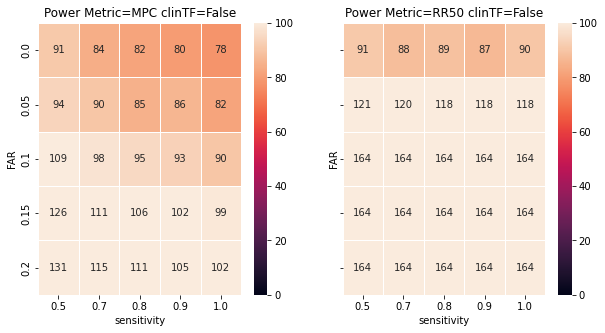

In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [1/3,2/3,2]:
    for clinTF in [True,False]:
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        drawGrid(fn,clinTF=clinTF)
        

In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from weargroup_v2 import buildSET_of_N,drawGrid
mini=False
for inflater in [.01,10,100]:
    for clinTF in [True,False]:
        fn = f'tryBigRange2_{clinTF}_nofar_inf{inflater}.csv'
        buildSET_of_N([0.5,.7,.8,.9,1],[0,0.05,.1,.15,.2],recalc=True,thiscsv=fn,clinTF=clinTF,REPS=10000,maxN=1500,DRG=0.2,mini=mini,inflater=inflater)
        #drawGrid(fn,clinTF=clinTF)

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 28.0 minutes
Saving....
Threshold ...1075. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1075  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...740. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  740


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1050. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1050


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 26.0 minutes
Saving....
Threshold ...900. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   900  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...1055. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1055  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...690. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...915. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  915


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...945. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  945


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...860. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   860  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1045. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1045  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...665. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  665


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...880. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  880


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...870. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  870


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...885. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   885  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 23.0 minutes
Saving....
Threshold ...1050. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1050  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...650. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  650


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...840. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  840


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   870  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1025. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1025  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...630. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  630


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...795. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  795


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 2.0 minutes
Threshold ...805. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  805
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   535
0          0.5  0.05  1075   565
0          0.5  0.10  1495   740
0          0.5  0.15  1495  1050
0          0.5  0.20  1495  1060
0          0.7  0.00   900   540
0          0.7  0.05  1055   555
0          0.7  0.10  1495   690
0          0.7  0.15  1495   915
0          0.7  0.20  1495   945
0          0.8  0.00   860   525
0          0.8  0.05  1045   545
0          0.8  0.10  1495   665
0          0.8  0.15  1495   880
0          0.8  0.20  1495   870
0          0.9  0.00   885   520
0          0.9  0.05  1050   530
0          0.9  0.10  1495   650
0          0.9  0.15  1495   840
0          0.9  0.20  1495   830
0          1.0  0.00   870   500
0          1.0  0.05  1025   525
0          1.0  0.10  1495   630
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 18.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...500. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   815  500


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1010. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1010  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...680. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.2  1495  680


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   810  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1005. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1005  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...595. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  595


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...615. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  615


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1030. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1030  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...805. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   805  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...460. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1020  460


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...555. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  555


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...435. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1020. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1020  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...495. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  545
   sensitivity   FAR  RR50  MPC
0          0.5  0.00   815  500
0          0.5  0.05  1010  510
0          0.5  0.10  1495  595
0          0.5  0.15  1495  675
0          0.5  0.20  1495  680
0          0.7  0.00   810  465
0          0.7  0.05  1005  480
0          0.7  0.10  1495  545
0          0.7  0.15  1495  595
0          0.7  0.20  1495  615
0          0.8  0.00   795  450
0          0.8  0.05  1030  460
0          0.8  0.10  1495  530
0          0.8  0.15  1495  565
0          0.8  0.20  1495  590
0          0.9  0.00   805  445
0          0.9  0.05  1020  460
0          0.9  0.10  1495  510
0          0.9  0.15  1495  555
0          0.9  0.20  1495  565
0          1.0  0.00   810  435
0          1.0  0.05  1020  450
0          1.0  0.10  1495  495
0          1.0  0.15  1495  540
0          1.0

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 31.0 minutes
Saving....
Threshold ...895. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   895  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...1250. runtime = 1.0 minutes
Threshold ...605. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1250  605


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...965. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  965


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   890  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 21.0 minutes
Saving....
Threshold ...1215. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1215  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...850. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  850


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1270. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1270


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   870  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 20.0 minutes
Saving....
Threshold ...1210. runtime = 1.0 minutes
Threshold ...575. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1210  575


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...820. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  820


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1200. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1200


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...525. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   880  525


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...1185. runtime = 1.0 minutes
Threshold ...565. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1185  565


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...790. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  790


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1120. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1120


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1465. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...865. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   865  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...1165. runtime = 1.0 minutes
Threshold ...550. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1165  550


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1060. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1060


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1370. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1370
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   895   545
0          0.5  0.05  1250   605
0          0.5  0.10  1495   965
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   890   540
0          0.7  0.05  1215   590
0          0.7  0.10  1495   850
0          0.7  0.15  1495  1270
0          0.7  0.20  1495  1495
0          0.8  0.00   870   525
0          0.8  0.05  1210   575
0          0.8  0.10  1495   820
0          0.8  0.15  1495  1200
0          0.8  0.20  1495  1495
0          0.9  0.00   880   525
0          0.9  0.05  1185   565
0          0.9  0.10  1495   790
0          0.9  0.15  1495  1120
0          0.9  0.20  1495  1465
0          1.0  0.00   865   510
0          1.0  0.05  1165   550
0          1.0  0.10  1495   770
0          1.0  0.1

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   810  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1140. runtime = 1.0 minutes
Threshold ...530. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.05  1140  530


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5  0.1  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...865. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.5  0.15  1495  865


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1035. runtime = 3.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1035


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...455. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   795  455


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1170. runtime = 1.0 minutes
Threshold ...505. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1170  505


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...600. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.1  1495  600


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...750. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.15  1495  750


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...875. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7  0.2  1495  875


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...800. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   800  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1120. runtime = 1.0 minutes
Threshold ...475. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1120  475


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...590. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.1  1495  590


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...690. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.15  1495  690


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...820. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8  0.2  1495  820


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...815. runtime = 1.0 minutes
Threshold ...445. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   815  445


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1105. runtime = 1.0 minutes
Threshold ...480. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1105  480


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...560. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.1  1495  560


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...675. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.15  1495  675


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...770. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9  0.2  1495  770


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...430. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   820  430


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1100. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1100  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...535. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.1  1495  535


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...635. runtime = 0.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.15  1495  635


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 10.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...725. runtime = 1.0 minutes
   sensitivity  FAR  RR50  MPC
0            1  0.2  1495  725
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   810   490
0          0.5  0.05  1140   530
0          0.5  0.10  1495   675
0          0.5  0.15  1495   865
0          0.5  0.20  1495  1035
0          0.7  0.00   795   455
0          0.7  0.05  1170   505
0          0.7  0.10  1495   600
0          0.7  0.15  1495   750
0          0.7  0.20  1495   875
0          0.8  0.00   800   445
0          0.8  0.05  1120   475
0          0.8  0.10  1495   590
0          0.8  0.15  1495   690
0          0.8  0.20  1495   820
0          0.9  0.00   815   445
0          0.9  0.05  1105   480
0          0.9  0.10  1495   560
0          0.9  0.15  1495   675
0          0.9  0.20  1495   770
0          1.0  0.00   820   430
0          1.0  0.05  1100   465
0          1.0  0.10  1495   535
0          1.0  0.15  

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 30.0 minutes
Saving....
Threshold ...890. runtime = 1.0 minutes
Threshold ...545. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   890  545


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 16.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...910. runtime = 1.0 minutes
Threshold ...540. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   910  540


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 25.0 minutes
Saving....
Threshold ...880. runtime = 1.0 minutes
Threshold ...520. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   880  520


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 15.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 22.0 minutes
Saving....
Threshold ...870. runtime = 1.0 minutes
Threshold ...510. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   870  510


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.05  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 19.0 minutes
Saving....
Threshold ...875. runtime = 1.0 minutes
Threshold ...515. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   875  515


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1450. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.05  1495  1450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1495
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   890   545
0          0.5  0.05  1495  1495
0          0.5  0.10  1495  1495
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   910   540
0          0.7  0.05  1495  1495
0          0.7  0.10  1495  1495
0          0.7  0.15  1495  1495
0          0.7  0.20  1495  1495
0          0.8  0.00   880   520
0          0.8  0.05  1495  1495
0          0.8  0.10  1495  1495
0          0.8  0.15  1495  1495
0          0.8  0.20  1495  1495
0          0.9  0.00   870   510
0          0.9  0.05  1495  1495
0          0.9  0.10  1495  1495
0          0.9  0.15  1495  1495
0          0.9  0.20  1495  1495
0          1.0  0.00   875   515
0          1.0  0.05  1495  1450
0          1.0  0.10  1495  1495
0          1.0  0.1

trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 17.0 minutes
Saving....
Threshold ...820. runtime = 1.0 minutes
Threshold ...490. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.5    0   820  490


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1150. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.05  1495  1150


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.5  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.5  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...465. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.7    0   810  465


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...970. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.7  0.05  1495  970


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.7  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.7  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 14.0 minutes
Saving....
Threshold ...795. runtime = 1.0 minutes
Threshold ...450. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.8    0   795  450


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...885. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.8  0.05  1495  885


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.1  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.8  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.8  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 13.0 minutes
Saving....
Threshold ...810. runtime = 1.0 minutes
Threshold ...440. runtime = 0.0 minutes
   sensitivity  FAR  RR50  MPC
0          0.9    0   810  440


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 12.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...830. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0          0.9  0.05  1495  830


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 47.0 minutes
Saving....
Threshold ...

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1495. runtime = 18.0 minutes
Threshold ...1395. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.1  1495  1395


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 24.0 minutes
Saving....
Threshold ...

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1495. runtime = 14.0 minutes
Threshold ...1495. runtime = 2.0 minutes
   sensitivity   FAR  RR50   MPC
0          0.9  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 110.0 minutes
Saving....
Threshold ...1495. runtime = 16.0 minutes
Threshold ...1495. runtime = 12.0 minutes
   sensitivity  FAR  RR50   MPC
0          0.9  0.2  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 99.0 minutes
Saving....
Threshold ...810. runtime = 8.0 minutes
Threshold ...435. runtime = 2.0 minutes
   sensitivity  FAR  RR50  MPC
0            1    0   810  435


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...810. runtime = 1.0 minutes
   sensitivity   FAR  RR50  MPC
0            1  0.05  1495  810


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1320. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.1  1495  1320


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity   FAR  RR50   MPC
0            1  0.15  1495  1495


trials:   0%|          | 0/10000 [00:00<?, ?it/s]

Calculating wins = 11.0 minutes
Saving....
Threshold ...1495. runtime = 1.0 minutes
Threshold ...1495. runtime = 1.0 minutes
   sensitivity  FAR  RR50   MPC
0            1  0.2  1495  1495
   sensitivity   FAR  RR50   MPC
0          0.5  0.00   820   490
0          0.5  0.05  1495  1150
0          0.5  0.10  1495  1495
0          0.5  0.15  1495  1495
0          0.5  0.20  1495  1495
0          0.7  0.00   810   465
0          0.7  0.05  1495   970
0          0.7  0.10  1495  1495
0          0.7  0.15  1495  1495
0          0.7  0.20  1495  1495
0          0.8  0.00   795   450
0          0.8  0.05  1495   885
0          0.8  0.10  1495  1495
0          0.8  0.15  1495  1495
0          0.8  0.20  1495  1495
0          0.9  0.00   810   440
0          0.9  0.05  1495   830
0          0.9  0.10  1495  1395
0          0.9  0.15  1495  1495
0          0.9  0.20  1495  1495
0          1.0  0.00   810   435
0          1.0  0.05  1495   810
0          1.0  0.10  1495  1320
0          1.0  0.1